Хотим узнать с каким вероятностным законом распределён рейтинг песни.

Для начала построим график

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [142]:
df = pd.read_csv('song_data.csv')
RATING = 'song_popularity'
data = df[RATING].dropna()


<Axes: ylabel='Frequency'>

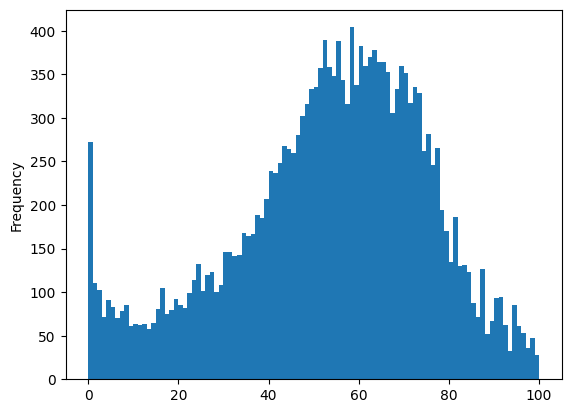

In [143]:
data.plot.hist(bins=100)

Если не учитывать песни с рейтингом 0 (что больше похоже на значние для заполнения пропусков или, что песню никто и не слушал), то можно предположть такую гипотезу:

 - $\space X \sim N(60, \sigma^2)$
 - $$

In [144]:

# data = data[data != 0]

mean= 52.99187682505973 
S_*^2= 479.8322143432033


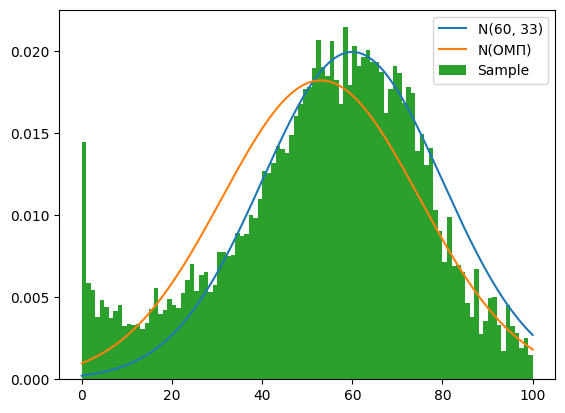

In [152]:
x = np.linspace(0, 100, 1000)

aprox_norm = stats.norm(60, 20)


sample_mean = sum(data) / len(data)
sample_var = sum([(x - sample_mean) ** 2 for x in data]) / len(data)
omp_norm = stats.norm(sample_mean, np.sqrt(sample_var))
print("mean=", sample_mean, "\nS_*^2=", sample_var)


norm = aprox_norm.pdf(x)
norm2 = omp_norm.pdf(x)

plt.plot(x, norm, label="N(60, 33)")
plt.plot(x, norm2, label="N(ОМП)")

plt.hist(data, bins=100, density=True, label="Sample")
plt.legend()
plt.show()

Воспользуемся критерием согласия Пирсона хи-квадрат

Воспользуемся дискретной апроксимацией нормального распределения.

$U \sim N(60, 20)$

$p_0 = (F_U(0), F_U(1) - F_U(0), F_U(2) - F_U(1), ... F_U(100) - F_U(99))$

$H_0: p = p_0$

$H_1: \space ! H_0$

уровень значимости поставим 0.05

In [146]:
def chi2(rnd, minus_df):
    sample_freq = [0] * 101
    for e in data:
        if e is None:
            continue
        sample_freq[e] += 1
    expected_freq = [0] * 101
    prev = 0
    for i in range(101):
        cur = rnd.cdf(i)
        expected_freq[i] = round((cur - prev) * len(data))
        prev = cur
    # expected_freq[100] = len(data) - sum(expected_freq)
    expected_freq = expected_freq[1:]
    sample_freq = sample_freq[1:]
    chi2_s = 0
    for i in range(len(expected_freq)):
        chi2_s += (sample_freq[i] - expected_freq[i])**2 / expected_freq[i]

    _df = len(expected_freq) - 1 - minus_df
    _p_value = stats.chi2.sf(chi2_s, df=_df)
    return chi2_s, _p_value
stat, p_value = chi2(aprox_norm, 0)

print("chi2: ", stat)
print("p_value: ", p_value)

alpha = 0.05

if p_value > alpha:
    print("Accept")
else:
    print("Reject")

chi2:  9697.608827852478
p_value:  0.0
Reject


Также попробем ещё вариацию теста хи-квадрат для оценок максмального правдоподобия

То есть таким образом проверяем сразу для всего класса нормальных распределений. В таком случае надо из степеней свободы вычесть количество параметров

$U \sim N(\mu, \sigma^2)$

$p_0 = (F_U(0), F_U(1) - F_U(0), F_U(2) - F_U(1), ... F_U(100) - F_U(99))$

$H_0: p = p_0$

$H_1: \space ! H_0$



In [147]:
stat, p_value = chi2(omp_norm, 2)
print("chi2: ", stat)
print("p_value: ", p_value)

alpha = 0.05

if p_value > alpha:
    print("Accept")
else:
    print("Reject")

chi2:  2121.9686233062157
p_value:  0.0
Reject


Воспользуемся тестом Шапиро

$H_0: X \sim N(\mu, \sigma)$

$H_1: \space !H_0$

In [150]:
import random

_data = list(data)
random.shuffle(_data)
stat, p_value = stats.shapiro(_data[:5000])
print("shapiro: ", stat)
print("p_value: ", p_value)

alpha = 0.05
if p_value > alpha:
    print("Accept")
else:
    print("Reject")

shapiro:  0.9749428265333937
p_value:  9.038871303551673e-29
Reject


И критерий согласия Колмагорова-Смирнова

$H_0: X \sim N(60, 20)$

$H_1: \space ! H_0$


In [149]:
# dataa = np.random.normal(loc=10, scale=1, size=1000)
statistic, p_value = stats.kstest(data, 'norm', args=(60, 20))
print(statistic, p_value)

if p_value > alpha:
    print("Accept")
else:
    print("Reject")

0.09846740877291571 2.0333125731509335e-159
Reject
